# PA005: High Value Costumers Identification

## 0.0. Planejamento da Solução (IoT)

### Input - Entrada

1. Problema de Negócio:
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjuntos de Dados:
    - Vendas de um e-commerce online, durante um período de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa Insiders:
    - Lista: client_id | is_insider |
             10232     | yes/1
             32412     | yes/1
    
2. Relatório com as respostas das perguntas de negócios:
    - Quem são as pessoas elegíveis para participar do programa de Insiders?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vindo dos Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao Insiders?
    - Quais as condições para uma pessoa ser removida do Insiders?
    - Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?


### Tasks - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível ? O que são clientes de maior "valor" ?
    - Faturamento:
        - Alto Ticket médio.
        - Alto LTV.
        - Baixo recência.
        - Alto basket size.
        - Baixa probabilidade de churn.
        - Alta previsão LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência de compra:
        - Média alta das avaliações
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes?
    - Escrever características do cliente: 
        - Idade
        - Localização 
        
    - Escrever características de consumo: 
        - Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vindo dos Insiders?
    - Faturamento total da empresa
    - Faturamento do grupo Insiders


5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort


6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a peridiocidade ( 1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo


7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a peridiocidade ( 1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de Hipóteses.


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferencia de compra
    - Frete
    - Visita a fabrica

# 0.0 Imports

In [111]:
import pandas as pd
import numpy as np
import re

import inflection
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [4]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 12
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
    
jupyter_settings()

## 0.2. Load Data

In [5]:
# Load Data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='ISO-8859-1')

df_raw = df_raw.loc[:,['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country']]

# 1.0. DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
# Get current columns name
cols_old = df1.columns

# Function to underscore
snakecase = lambda x: inflection.underscore(x)

# New columns name list
cols_new = list( map(snakecase, cols_old) )

# rename columns
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
# Remove NA
df1 = df1.dropna( subset=['description', 'customer_id'])
print('Removed {:.2f} of data' .format( ( 1 - (df1.shape[0] / df_raw.shape[0]))))

Removed 0.25 of data


In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtypes

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [14]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [15]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format= '%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64') 

In [96]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [97]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [106]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2,d3,d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['atributes','min','max','range','mean','median','std','skew','kurtosis']
m

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.1.1. Numerical Attributes Investigating

- Quantity Negative ( pode ser devolução )
- Preço unitário igual a zero ( pode ser promoção ? )

### 1.7.2. Categorical Attributes

In [107]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [125]:
# invoice_no
index = cat_attributes['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ) ) )
at_least_one_string_invoice_no = cat_attributes.loc[index,['invoice_no']].nunique()[0]

# stock_code
index = cat_attributes['stock_code'].apply(lambda x: bool(re.search( '[^0-9]+', x ) ) )
at_least_one_string_stock_code = cat_attributes.loc[index,['stock_code']].nunique()[0]

print('invoice_no with string: {}' .format(at_least_one_string_invoice_no))
print('stock_code with string: {}' .format(at_least_one_string_stock_code))

invoice_no with string: 3654
stock_code with string: 886


In [123]:
at_least_one_string_invoice_no[0]

3654

# 2.0. Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1. Feature Creation

In [17]:
# data reference
df_ref = df2.loc[:, ['customer_id']].drop_duplicates( ignore_index=True )

In [95]:
# Gross Revenue (Faturamento) : quantity*price
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

# Monetary 
df_monetary = df2[['customer_id','gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency - Last day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency.loc[:, ['customer_id','recency_days']].copy()

df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates( ignore_index=True ).groupby('customer_id').count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# Avg ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )

# 3.0. Filtragem de Variáveis

In [45]:
df3 = df_ref.copy()

# 4.0. EDA - (Exploratory Data Analysis)

In [46]:
df4 = df3.copy()

# 5.0. DATA PREPARATION

In [47]:
df5 = df4.copy()

# 6.0. FEATURE SELECTION

In [48]:
df6 = df5.copy()

# 7.0. HYPERPARAMETER FINE-TUNNING

In [49]:
X = df6.drop(columns=['customer_id'])

In [50]:
clusters = [2,3,4,5,6,7]

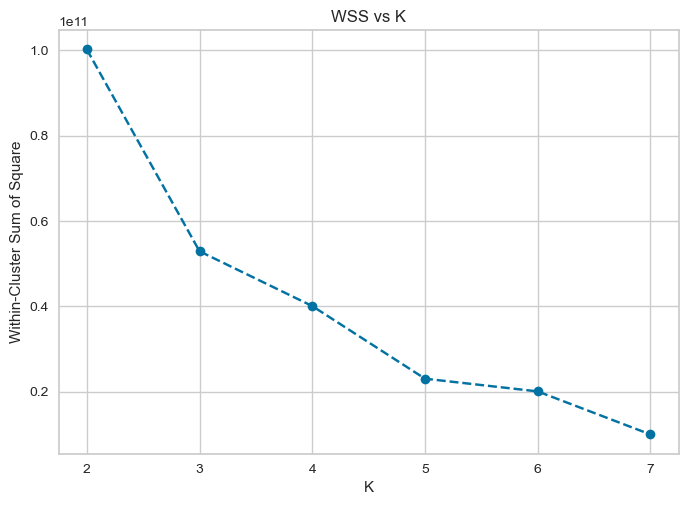

In [51]:
wss = []

for k in clusters:
    # Model Definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    
    # Model Training
    kmeans.fit( X )
    
    # Validation
    wss.append( kmeans.inertia_ )
    
# plot wss - Elbow method
plt.plot( clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

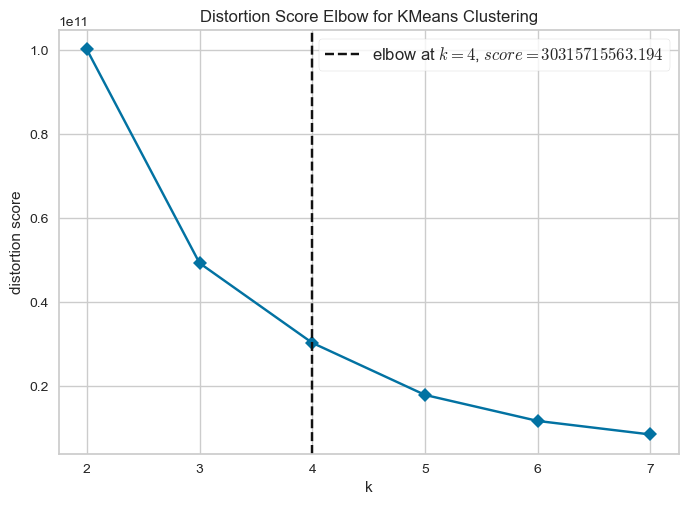

In [53]:
kmeans = KElbowVisualizer( c.KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show();

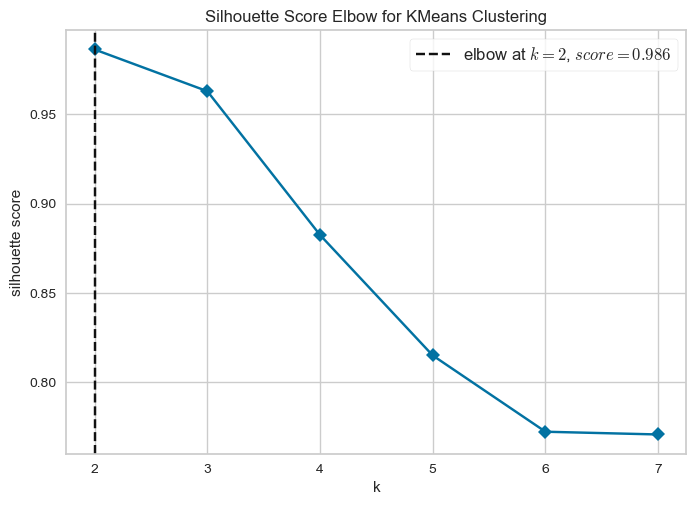

In [54]:
kmeans = KElbowVisualizer( c.KMeans(n_init=10), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X )
kmeans.show();

## 7.1. Silhouette Analysis 

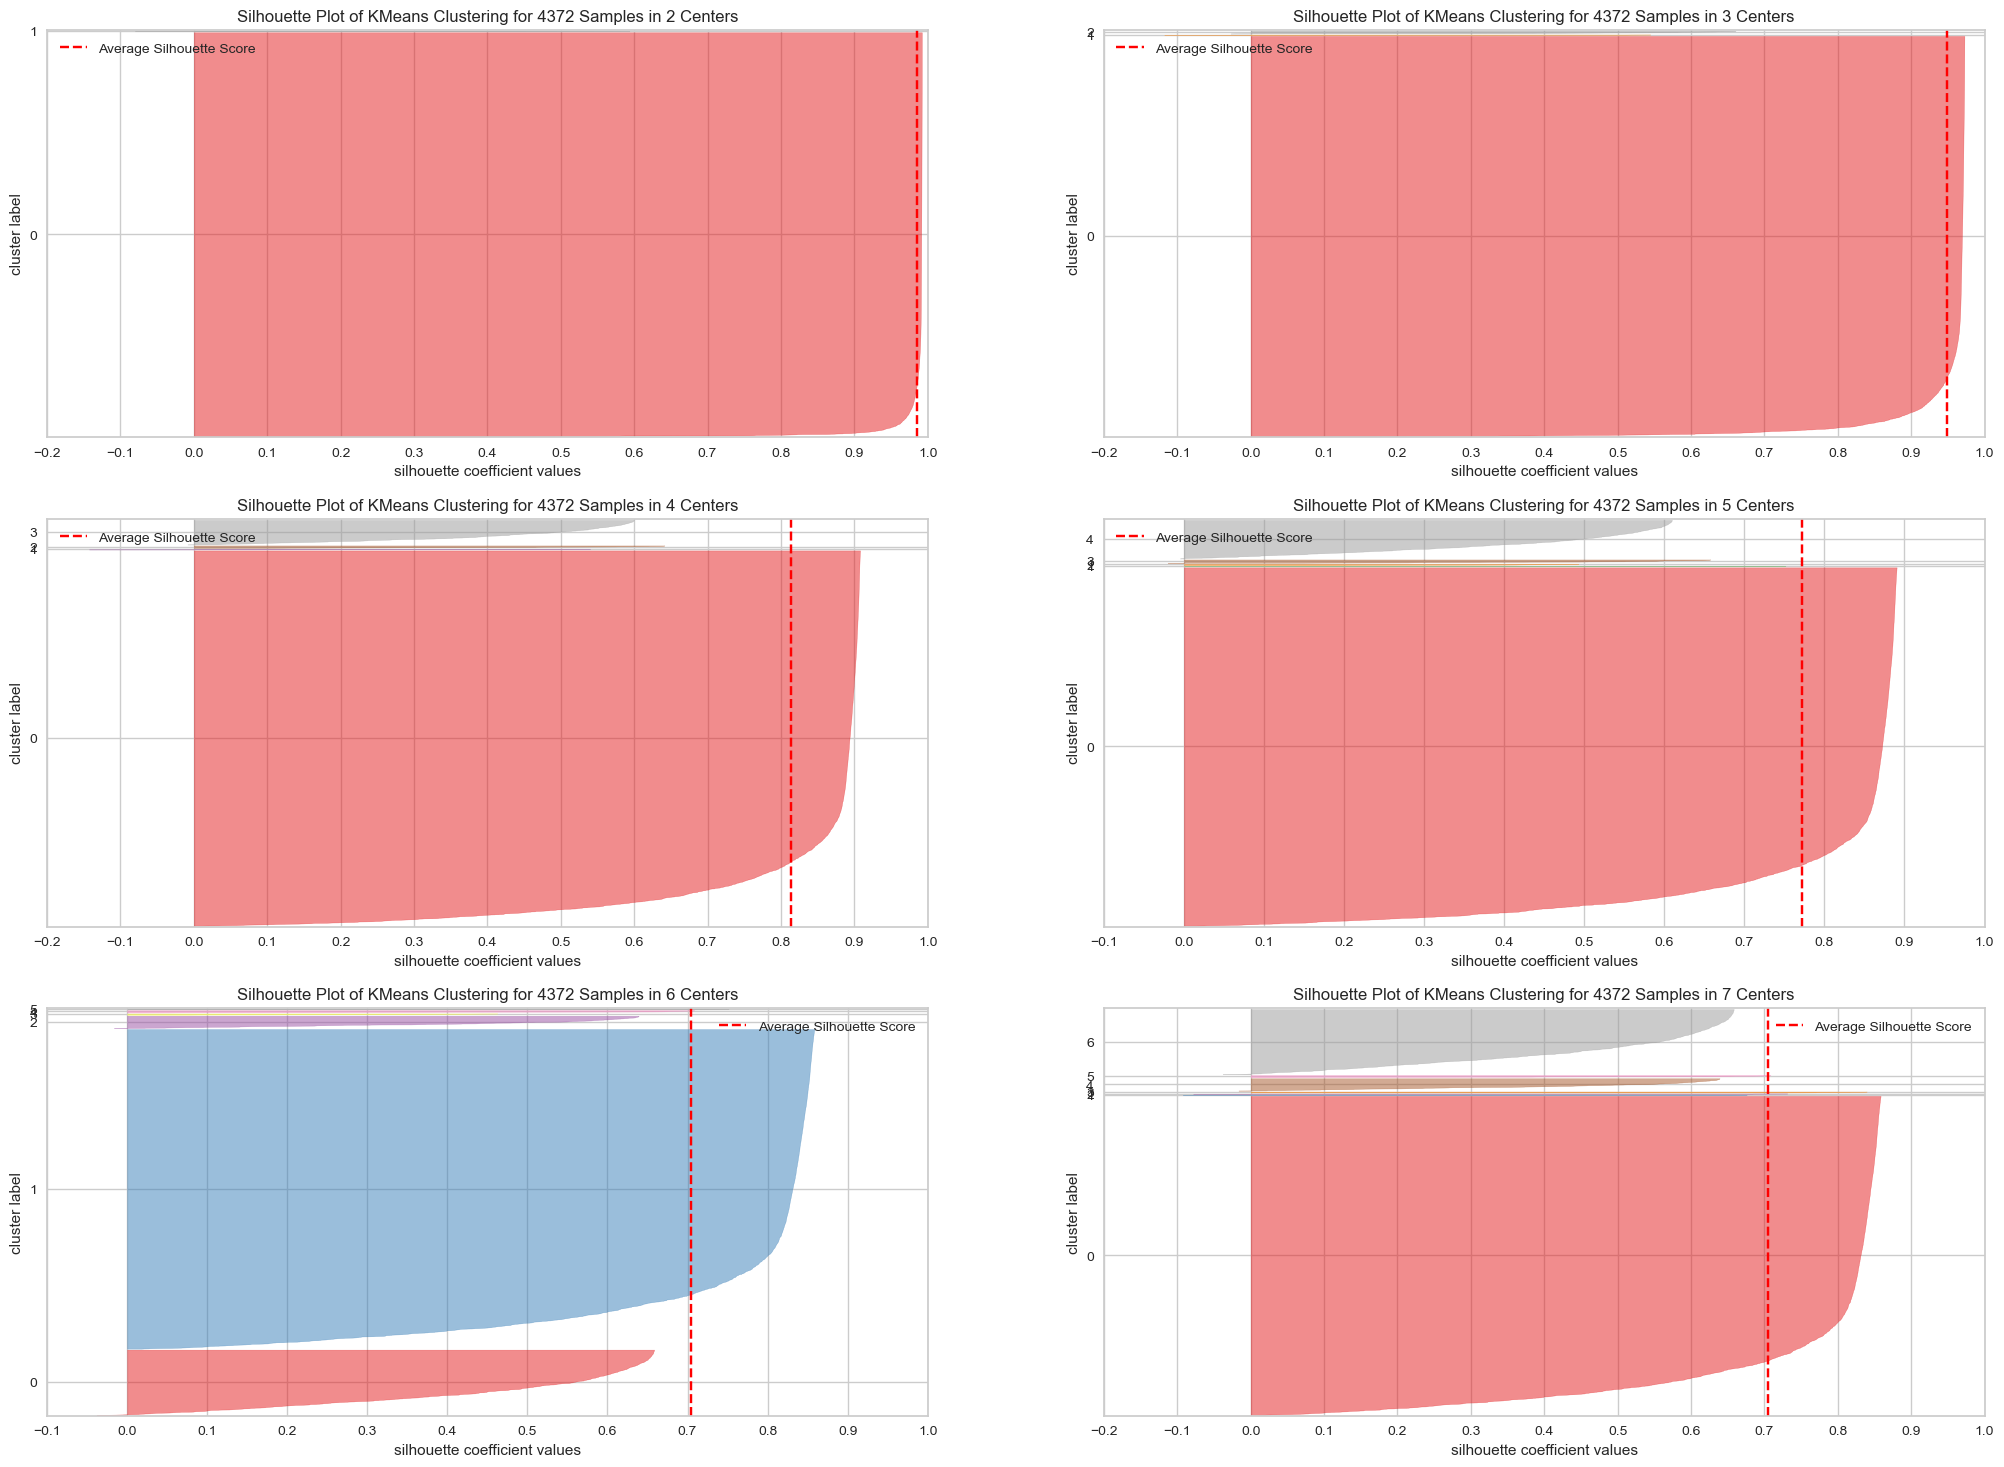

In [69]:
fig, ax = plt.subplots(3,2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    q, mod= divmod( k, 2 )
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0. MODEL TRAINING

## 8.1. K-Means

In [84]:
# model definition
k = 4

kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [71]:
## WSS ( Within-cluster sum of square )
print('WSS value: {}' .format(kmeans.inertia_) )

## SS ( Silhouette Score )
print('SS value: {:.4f}' .format( m.silhouette_score( X, labels, metric='euclidean') ) )

WSS value: 40056506734.602486
SS value: 0.8140


# 9.0. CLUSTER ANALYSIS

In [78]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.1. Visualization Inspection

C:\Users\leonardo.ribeiro\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



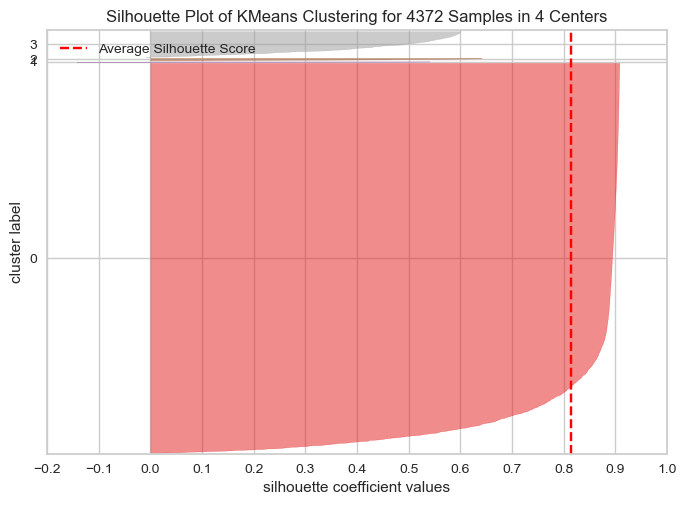

In [86]:
visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

- Ao plotar as features em pares, conseguimos ver se os dados estão bagunçados ou não, ou seja, se os clusteres estão bem divididos ou não. 
- A desvantagem é que ao plotar em 2D pode ser que alguma informação seja perdida, por exemplo, pode ser que na alta dimensionalidade (3 features ou +) , os clusteres ficariam bem divididos

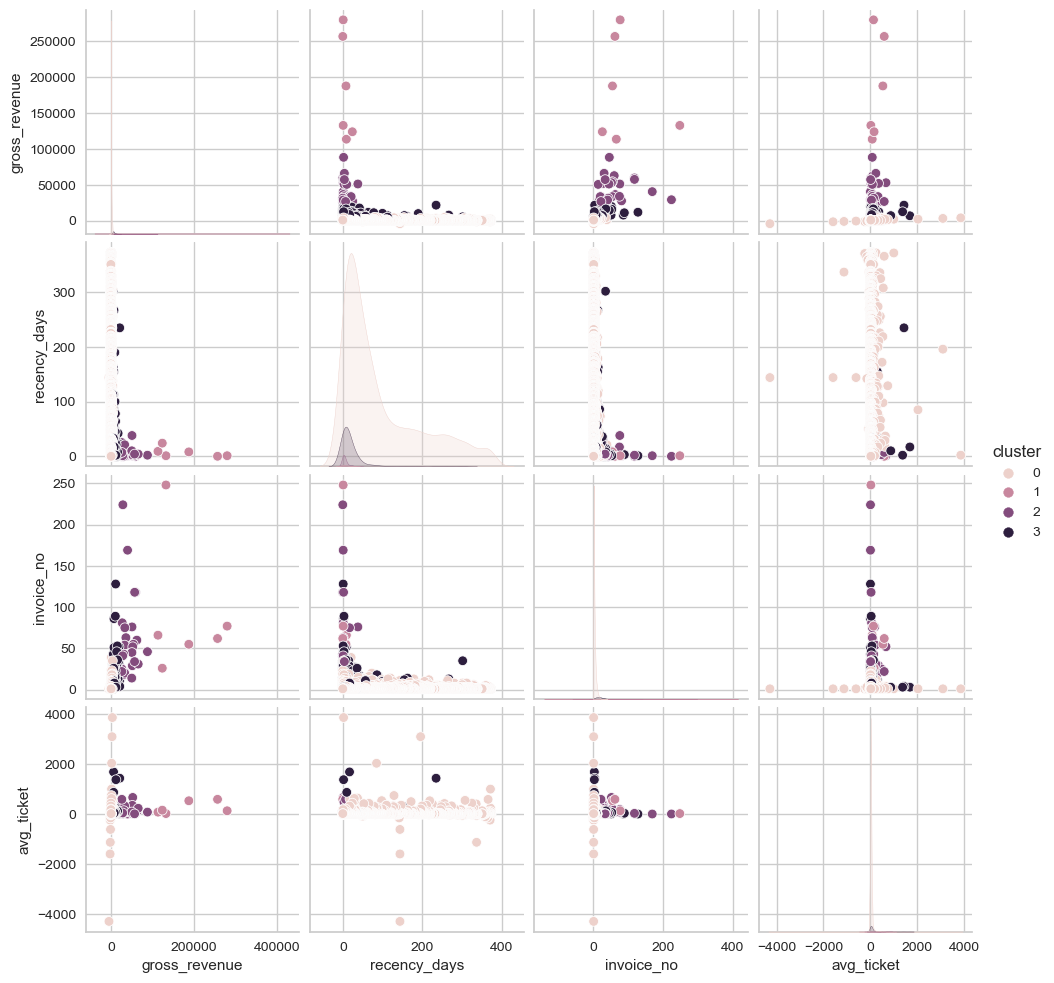

In [88]:
df_viz = df9.drop(columns=['customer_id'], axis=1 )

sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP

- Pontos da mesma cor próximos um dos outros, significa que na alta dimensionalidade há uma alta probabilidade de também estarém próximos

In [90]:
import umap.umap_ as umap

C:\Users\leonardo.ribeiro\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='embedding_x', ylabel='embedding_y'>

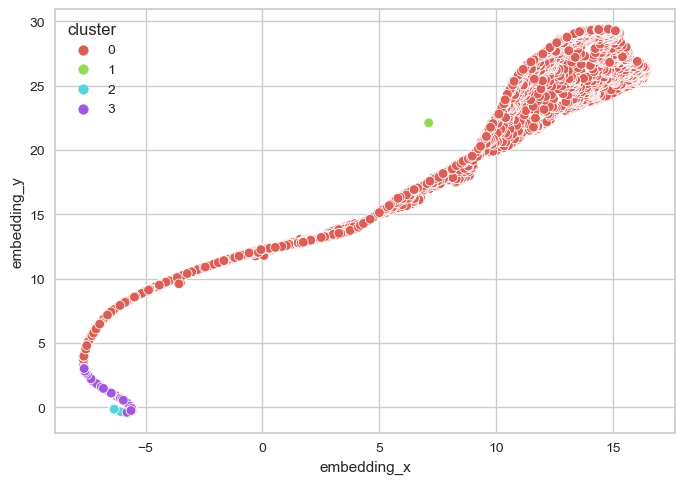

In [93]:
reducer = umap.UMAP( n_neighbors=3000, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len( df_viz['cluster'].unique() ) ), 
                data=df_viz ) 

## 9.1. Visualization Inspection

In [74]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show()

## 9.2. Cluster Profile

In [94]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue 
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')


# Avg Recency days
df_avg_revency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_revency_days, how='inner', on='cluster')

# Avg invoice no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 01 (Candidato a Insider) 
    - Número de customers: 6 (0.14% dos customers)
    - Recência média:  7 dias
    - Compras em média: 89 compras 
    - Receita em média: $182.182,00 dólares
    
### Cluster 02
    - Número de customers: 31 (0.70% dos customers)
    - Recência média: 13 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,00 dólares

### Cluster 03
    - Número de customers: 4335 (99.16% dos customers)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372 dólares

# 10.0. Deploy to Production

In [38]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0
